# Computación Paralela
## Edición de imágenes

*María Graciel Cruz Cáceres*

*Departamento de Ciencia de la Computación*
*Universidad Católica San Pablo*
*Arequipa - Perú*

## Enlace al repositorio
[Github](https://github.com/magrcruz/ComputacionParalela/tree/main/FiltrosImagenesCUDA) - https://github.com/magrcruz/ComputacionParalela/tree/main/FiltrosImagenesCUDA

## Codigos completos

### Conversion a escala de grises

In [1]:
%%writefile color2gray.cu
#include <stdio.h>
#include <stdlib.h>
#include <math.h>
#include <cuda.h>
#include<time.h>
#include <opencv2/core/core.hpp>
#include <opencv2/imgproc/imgproc.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <opencv2/opencv.hpp>
#include <opencv2/imgcodecs.hpp>
#include "device_launch_parameters.h"
#include "GpuTimer.h"

#define CV_LOAD_IMAGE_COLOR cv::IMREAD_COLOR

using namespace cv;
using namespace std;

// cpu implementation
void rgb2grayCPU(unsigned char* color, unsigned char* gray, int numRows, int numCols, int numChannels) {
    int grayOffset, colorOffset;

    for (int i = 0; i < numRows; i++) {
        for (int j = 0; j < numCols; j++) {
            // linearize pixel coordinate tuple (i, j)
            grayOffset = i * numCols + j;
            colorOffset = grayOffset * numChannels;

            // convert to gray
            gray[grayOffset] = (0.21 * color[colorOffset + 2]) +
                               (0.71 * color[colorOffset + 1]) +
                               (0.07 * color[colorOffset]);
       }
   }
}

// gpu implementation
__global__ void rgb2grayGPU(unsigned char* Pout, unsigned char* Pin, int width, int height, int numChannels) {
    // compute global thread coordinates
    int row = threadIdx.y + blockIdx.y*blockDim.y;
    int col = threadIdx.x + blockIdx.x*blockDim.x;

    // linearize coordinates for data access
    int grayOffset = row * width + col;
    int colorOffset = grayOffset * numChannels;

    if ((col < width) && (row < height)) {
        Pout[grayOffset] = (0.21 * Pin[colorOffset + 2]) +
                           (0.71 * Pin[colorOffset + 1]) +
                           (0.07 * Pin[colorOffset]);
    }
}

int main(int argc, char *argv[]) {
    if (argc == 1) {
        printf("[!] Filename expected.\n");
        return 0;
    }

    // read image
    Mat image;
    image = imread(argv[1], CV_LOAD_IMAGE_COLOR);
    if (image.empty()) {
        printf("Cannot read image file %s", argv[1]);
        exit(1);
    }

    // define img params and timers
    int imageChannels = 3;
    int imageWidth = image.cols;
    int imageHeight = image.rows;
    size_t size_rgb = sizeof(unsigned char)*imageWidth*imageHeight*imageChannels;
    size_t size_gray = sizeof(unsigned char)*imageWidth*imageHeight;
    GpuTimer timer, timer1, timer2, timer3;

    // allocate mem for host image vectors
    unsigned char* h_grayImage = (unsigned char*)malloc(size_rgb);
    unsigned char* h_grayImage_CPU = (unsigned char*)malloc(size_rgb);

    // grab pointer to host rgb image
    unsigned char* h_rgbImage = image.data;

    // allocate mem for device rgb and gray
    unsigned char* d_rgbImage;
    unsigned char* d_grayImage;
    timer.Start();
    cudaMalloc((void**)&d_rgbImage, size_rgb);
    cudaMalloc((void**)&d_grayImage, size_gray);
    timer.Stop();
    float d_t0 = timer.Elapsed();
    printf("Time to allocate memory on the device is: %f msecs.\n", d_t0);

    // copy the rgb image from the host to the device and record the needed time
    timer1.Start();
    cudaMemcpy(d_rgbImage, h_rgbImage, size_rgb, cudaMemcpyHostToDevice);
    timer1.Stop();
    float d_t1 = timer1.Elapsed();
    printf("Time to copy the RGB image from the host to the device is: %f msecs.\n", d_t1);

    // execution configuration parameters + kernel launch
    dim3 dimBlock(16, 16, 1);
    dim3 dimGrid(ceil(imageWidth/16.0), ceil(imageHeight/16.0), 1);
    timer2.Start();
    rgb2grayGPU<<<dimGrid, dimBlock>>>(d_grayImage, d_rgbImage, imageWidth, imageHeight, imageChannels);
    timer2.Stop();
    float d_t2 = timer2.Elapsed();
    printf("Implemented CUDA code ran in: %f msecs.\n", d_t2);

    // copy gray image from device to host
    timer3.Start();
    cudaMemcpy(h_grayImage, d_grayImage, size_gray, cudaMemcpyDeviceToHost);
    timer3.Stop();
    float d_t3 = timer.Elapsed();
    printf("Time to copy the Gray image from the device to the host is: %f msecs.\n", d_t3);

    // do the processing on the CPU
    clock_t begin = clock();
    rgb2grayCPU(h_rgbImage, h_grayImage_CPU, imageHeight, imageWidth, imageChannels);
    clock_t end = clock();

    // calculate total time for CPU and GPU
    double time_spent = (double)(end - begin) / CLOCKS_PER_SEC*1000;
    printf("Total CPU code ran in: %f msecs.\n", time_spent);
    float total_device_time = d_t0 + d_t1 + d_t2 + d_t3;
    printf("Total GPU code ran in: %f msecs.\n", total_device_time);
    float speedup = (float)time_spent / total_device_time;
    printf("GPU Speedup: %f\n", speedup);


    Mat Image1(imageHeight, imageWidth, CV_8UC1, h_grayImage);
    Mat Image2(imageHeight, imageWidth, CV_8UC1, h_grayImage_CPU);
    imwrite("ImagenGrises.jpg", Image1);
    imwrite("ImagenGrisesCPU.jpg", Image2);

    // free host and device memory
    image.release();
    Image1.release();
    Image2.release();
    free(h_grayImage);
    free(h_grayImage_CPU);
    cudaFree(d_rgbImage); cudaFree(d_grayImage);

    return 0;
}

Writing color2gray.cu


### Filtro Blur

In [2]:
%%writefile imgBlur.cu
#include <opencv2/core/core.hpp>
#include <opencv2/imgproc/imgproc.hpp>
#include <opencv2/highgui/highgui.hpp>
#include<opencv2/opencv.hpp>
#include <iostream>
#include <cuda_runtime.h>
#include "device_launch_parameters.h"
#include "GpuTimer.h"
#include<time.h>

using namespace cv;
using namespace std;

#define CV_LOAD_IMAGE_COLOR cv::IMREAD_COLOR
#define CV_LOAD_IMAGE_GRAYSCALE cv::IMREAD_GRAYSCALE
#define FILTER_SIZE 11
#define BLOCK_SIZE 16

// imgBlurCPU blurs an image on the CPU
void imgBlurCPU(unsigned char* outImg, unsigned char* inImg, int width, int height) {
    int cumSum, numPixels;
    int cornerRow, cornerCol;
    int filterRow, filterCol;
    int filterSize = 2*FILTER_SIZE + 1;

    // loop through the pixels in the output image
    for (int row = 0; row < height; row++) {
        for (int col = 0; col < width; col++) {
            // compute coordinates of top-left corner
            cornerRow = row - FILTER_SIZE;
            cornerCol = col - FILTER_SIZE;

            // reset accumulator
            numPixels = 0;
            cumSum = 0;

            // accumulate values inside filter
            for (int i = 0; i < filterSize; i++) {
                for (int j = 0; j < filterSize; j++) {
                    // compute pixel coordinates inside filter
                    filterRow = cornerRow + i;
                    filterCol = cornerCol + j;

                    // make sure we are within image boundaries
                    if ((filterRow >= 0) && (filterRow <= height) && (filterCol >= 0) && (filterCol <= width)) {
                        // accumulate sum
                        cumSum += inImg[filterRow*width + filterCol];
                        numPixels++;
                    }
                }
            }
            // set the value of output
            outImg[row*width + col] = (unsigned char)(cumSum / numPixels);
        }
    }
}

// imgBlurGPU blurs an image on the GPU
__global__ void imgBlurGPU(unsigned char* outImg, unsigned char* inImg, int width, int height) {
    int filterRow, filterCol;
    int cornerRow, cornerCol;
    int tx = threadIdx.x; int ty = threadIdx.y;
    int bx = blockIdx.x; int by = blockIdx.y;
    int filterSize = 2*FILTER_SIZE + 1;

    // compute global thread coordinates
    int row = by * blockDim.y + ty;
    int col = bx * blockDim.x + tx;

    // make sure thread is within image boundaries
    if ((row < height) && (col < width)) {
        // instantiate accumulator
        int numPixels = 0;
        int cumSum = 0;

        // top-left corner coordinates
        cornerRow = row - FILTER_SIZE;
        cornerCol = col - FILTER_SIZE;

        // accumulate values inside filter
        for (int i = 0; i < filterSize; i++) {
            for (int j = 0; j < filterSize; j++) {
                // filter coordinates
                filterRow = cornerRow + i;
                filterCol = cornerCol + j;

                // accumulate sum
                if ((filterRow >= 0) && (filterRow <= height) && (filterCol >= 0) && (filterCol <= width)) {
                    cumSum += inImg[filterRow*width + filterCol];
                    numPixels++;
                }
            }
        }
        // set the value of output
        outImg[row*width + col] = (unsigned char)(cumSum / numPixels);
    }
}

int main(int argc, char *argv[]) {
    // make sure filename given
    if (argc == 1) {
        printf("[!] Filename expected.\n");
        return 0;
    }

    // read image
    Mat img;
    img = imread(argv[1], CV_LOAD_IMAGE_GRAYSCALE);
    if (img.empty()) {
        printf("Cannot read image file %s", argv[1]);
        exit(1);
    }

    // define img params and timers
    int imgWidth = img.cols;
    int imgHeight = img.rows;
    size_t imgSize = sizeof(unsigned char)*imgWidth*imgHeight;
    GpuTimer timer, timer1, timer2, timer3;

    // allocate mem for host output image vectors
    unsigned char* h_outImg = (unsigned char*)malloc(imgSize);
    unsigned char* h_outImg_CPU = (unsigned char*)malloc(imgSize);

    // grab pointer to host input image
    unsigned char* h_inImg = img.data;

    // allocate mem for device input and output
    unsigned char* d_inImg;
    unsigned char* d_outImg;
    timer.Start();
    cudaMalloc((void**)&d_inImg, imgSize);
    cudaMalloc((void**)&d_outImg, imgSize);
    timer.Stop();
    float d_t0 = timer.Elapsed();
    printf("Time to allocate memory on the device is: %f msecs.\n", d_t0);

    // copy the input image from the host to the device and record the needed time
    timer1.Start();
    cudaMemcpy(d_inImg, h_inImg, imgSize, cudaMemcpyHostToDevice);
    timer1.Stop();
    float d_t1 = timer1.Elapsed();
    printf("Time to copy the input image from the host to the device is: %f msecs.\n", d_t1);

    // execution configuration parameters + kernel launch
    dim3 dimBlock(16, 16, 1);
    dim3 dimGrid(ceil(imgWidth/16.0), ceil(imgHeight/16.0), 1);
    timer2.Start();
    imgBlurGPU<<<dimGrid, dimBlock>>>(d_outImg, d_inImg, imgWidth, imgHeight);
    timer2.Stop();
    float d_t2 = timer2.Elapsed();
    printf("Implemented CUDA code ran in: %f msecs.\n", d_t2);

    // copy output image from device to host
    timer3.Start();
    cudaMemcpy(h_outImg, d_outImg, imgSize, cudaMemcpyDeviceToHost);
    timer3.Stop();
    float d_t3 = timer.Elapsed();
    printf("Time to copy the Gray image from the device to the host is: %f msecs.\n", d_t3);

    // do the processing on the CPU
    clock_t begin = clock();
    imgBlurCPU(h_outImg_CPU, h_inImg, imgWidth, imgHeight);
    clock_t end = clock();

    // calculate total time for CPU and GPU
    double time_spent = (double)(end - begin) / CLOCKS_PER_SEC*1000;
    printf("Total CPU code ran in: %f msecs.\n", time_spent);
    float total_device_time = d_t0 + d_t1 + d_t2 + d_t3;
    printf("Total GPU code ran in: %f msecs.\n", total_device_time);
    float speedup = (float)time_spent / total_device_time;
    printf("GPU Speedup: %f\n", speedup);

    Mat Image1(imgHeight, imgWidth, CV_8UC1, h_outImg);
    Mat Image2(imgHeight, imgWidth, CV_8UC1, h_outImg_CPU);
    imwrite("ImagenBlur.jpg", Image1);
    imwrite("ImagenBlurCPU.jpg", Image2);

    // free host and device memory
    img.release(); Image1.release(); Image2.release();
    free(h_outImg_CPU); free(h_outImg);
    cudaFree(d_outImg); cudaFree(d_inImg);

    return 0;
}

Writing imgBlur.cu


## Introducción
Se implementaron las técnicas para convertir una imagen a escala de grises y la aplicación de filtro blur en CUDA. Los códigos se ejecutaron en Colab

# Comprobar que CUDA este funcionando correctamente

In [3]:
# Comprobar que Cuda toolkit este instalado
!ls /usr/local

bin    cuda	cuda-11.8  games	       include	lib64	   man	 share
colab  cuda-11	etc	   _gcs_config_ops.so  lib	licensing  sbin  src


In [4]:
# Comprobar si se tiene el comando nvcc
!which nvcc

/usr/local/cuda/bin/nvcc


In [5]:
# Escribir archivo hello world para cuda
%%writefile hello.cu

#include <cstdio>
#include <cuda.h>
__global__ void hello(void)
{
  printf("GPU: Hello!\n");
}
int main(int argc,char **argv)
{
  printf("CPU: Hello!\n");
  hello<<<1,10>>>();
  cudaDeviceReset();
  return 0;
}


Writing hello.cu


In [6]:
# Compilar hello.cu
!nvcc -arch=sm_37 -gencode=arch=compute_37,code=sm_37 hello.cu -o hello

nvcc warning : The 'compute_35', 'compute_37', 'sm_35', and 'sm_37' architectures are deprecated, and may be removed in a future release (Use -Wno-deprecated-gpu-targets to suppress warning).


In [7]:
# Ejecutar programa
!./hello

CPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!
GPU: Hello!


Cuda esta funcionando correctamente.

# Experimentos


## Instalar dependencias

In [8]:
# Instalar opencv
!apt-get -qq install -y libopencv-dev

In [9]:
# Archivo para tomar tiempos
%%writefile GpuTimer.h
#ifndef __GPU_TIMER_H__
#define __GPU_TIMER_H__

struct GpuTimer{
      cudaEvent_t start;
      cudaEvent_t stop;

      GpuTimer(){
            cudaEventCreate(&start);
            cudaEventCreate(&stop);
      }

      ~GpuTimer(){
            cudaEventDestroy(start);
            cudaEventDestroy(stop);
      }

      void Start(){cudaEventRecord(start, 0);}

      void Stop(){cudaEventRecord(stop, 0);}

      float Elapsed(){
            float elapsed;
            cudaEventSynchronize(stop);
            cudaEventElapsedTime(&elapsed, start, stop);
            return elapsed;
      }
};

#endif  /* __GPU_TIMER_H__ */

Writing GpuTimer.h


## Imagen a probar
Obtener una imagen para probar

In [10]:
!curl --output 'Imagen.jpg' 'https://cdna.artstation.com/p/assets/images/images/038/484/522/large/sofa-7.jpg'

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  435k  100  435k    0     0   386k      0  0:00:01  0:00:01 --:--:--  386k


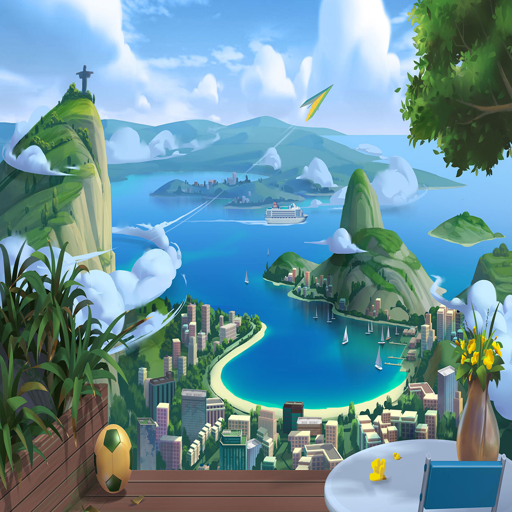

In [11]:
from PIL import Image
import ipywidgets as widgets
from IPython import display

img = Image.open('Imagen.jpg').resize((512, 512))
display.display(img)

## Imagen a escala de grises

### Inicializacion


Para manejar las imagenes utilizare la libreria de opencv


```cpp
#include <opencv2/core/core.hpp>
#include <opencv2/imgproc/imgproc.hpp>
#include <opencv2/highgui/highgui.hpp>
#include <opencv2/opencv.hpp>
#include <opencv2/imgcodecs.hpp>

using namespace cv;
```

Para realizar una comparacion de tiempos de la version en GPU y CPU e ejecutar ambas versiones y calculara el Speed Up


Reservaremos memoria para almacenar la imagen

```cpp
    unsigned char* h_grayImage = (unsigned char*)malloc(size_rgb);
    unsigned char* h_grayImage_CPU = (unsigned char*)malloc(size_rgb);
```


### Funcion para convertir la imagen



En primer lugar la implementacion en CPU

```cpp
void rgb2grayCPU(unsigned char* color, unsigned char* gray, int numRows, int numCols, int numChannels) {
    int grayOffset, colorOffset;

    for (int i = 0; i < numRows; i++) {
        for (int j = 0; j < numCols; j++) {
            // Calcula la cordenada para obtener el valor de la matriz en posicion i,j tomando en cuenta los canales
            grayOffset = i * numCols + j;
            colorOffset = grayOffset * numChannels;

            // Aplica la formula para convertir de gris a color
            gray[grayOffset] = (0.21 * color[colorOffset + 2]) +
                               (0.71 * color[colorOffset + 1]) +
                               (0.07 * color[colorOffset]);
       }
   }
}
```

Y tenemos la implementacion en GPU.
Lo que cambia en comparacion al anterior codigo es que en este caso no realizamos el for y tenemos que calcular la posicion i,j en este caso row, col en base al id del thread y el bloque en el que esta.

```cpp
__global__ void rgb2grayGPU(unsigned char* Pout, unsigned char* Pin, int width, int height, int numChannels) {
    // compute global thread coordinates
    int row = threadIdx.y + blockIdx.y*blockDim.y;
    int col = threadIdx.x + blockIdx.x*blockDim.x;

    // linearize coordinates for data access
    int grayOffset = row * width + col;
    int colorOffset = grayOffset * numChannels;

    if ((col < width) && (row < height)) {
        Pout[grayOffset] = (0.21 * Pin[colorOffset + 2]) +
                           (0.71 * Pin[colorOffset + 1]) +
                           (0.07 * Pin[colorOffset]);
    }
}
```

### Codigo para ejecutar la conversion

Primero para ejecutarlo reservamos la memoria necesaria.



En el caso de GPU reservamos memoria en CUDA

```cpp
    cudaMalloc((void**)&d_rgbImage, size_rgb);
    cudaMalloc((void**)&d_grayImage, size_gray);
```

Movemos los datos de device a host

```cpp
    cudaMemcpy(d_rgbImage, h_rgbImage, size_rgb, cudaMemcpyHostToDevice);
```

Definimos el tamaño del Bloque y de la Grilla

```cpp
    dim3 dimBlock(16, 16, 1);
    dim3 dimGrid(ceil(imageWidth/16.0), ceil(imageHeight/16.0), 1);
```

Ejecutamos el codigo


```cpp
    rgb2grayGPU<<<dimGrid, dimBlock>>>(d_grayImage, d_rgbImage, imageWidth, imageHeight, imageChannels);
```

Y copiamos los resultados de regreso al device


```cpp
    cudaMemcpy(h_grayImage, d_grayImage, size_gray, cudaMemcpyDeviceToHost);
```

Para la conversion en CPU simplemente ejecutamos la funcion

### Finalizar el codigo

Guardamos ambas imagenes

```cpp
    Mat Image1(imageHeight, imageWidth, CV_8UC1, h_grayImage);
    Mat Image2(imageHeight, imageWidth, CV_8UC1, h_grayImage_CPU);
    imwrite("GPUImage.jpg", Image1);
    imwrite("CPUImage.jpg", Image2);
```

Y liberamos la memoria


```cpp
    image.release();
    Image1.release();
    Image2.release();
    free(h_grayImage);
    free(h_grayImage_CPU);
    cudaFree(d_rgbImage);
    cudaFree(d_grayImage);
```

### Ejecucion del codigo

Compilamos el codigo

In [12]:
# Compilar archivo de filtro de grises
!nvcc -I/usr/include/opencv4 -L/usr/lib -o color2gray color2gray.cu -lopencv_core -lopencv_highgui -lopencv_imgcodecs

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::MultiBandBlender"

/usr/include/opencv4/opencv2/videostab/motion_stabilizing.hpp(106): warning #997-D: function "cv::videostab::IMotionStabilizer::stabilize(int, const std::vector<cv::

Lo ejecutamos

In [13]:
# Ejecucion del codigo
!./color2gray Imagen.jpg

Time to allocate memory on the device is: 0.227360 msecs.
Time to copy the RGB image from the host to the device is: 1.665248 msecs.
Implemented CUDA code ran in: 0.390304 msecs.
Time to copy the Gray image from the device to the host is: 0.227360 msecs.
Total CPU code ran in: 15.013000 msecs.
Total GPU code ran in: 2.510272 msecs.
GPU Speedup: 5.980627


Y podemos visualizar los tiempos que se demora en ejecutar la conversion y observamos el SpeedUp

### Visualizacion del resultado de la conversión de imágenes

In [14]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

# Ruta de las imágenes
imagen1_path = 'Imagen.jpg'
imagen2_path = 'ImagenGrises.jpg'

# Cargar las imágenes
imagen1 = Image.open(imagen1_path)
imagen2 = Image.open(imagen2_path)

# Crear widgets de imagen
widget_imagen1 = widgets.Image(value=imagen1._repr_png_(), format='png', width=400, height=400)
widget_imagen2 = widgets.Image(value=imagen2._repr_png_(), format='png', width=400, height=400)

# Crear cajas de widgets para cada imagen
caja_imagen1 = widgets.VBox([widgets.Label('Imagen original'), widget_imagen1])
caja_imagen2 = widgets.VBox([widgets.Label('Escala de grises'), widget_imagen2])

# Mostrar las cajas de widgets
display(widgets.HBox([caja_imagen1, caja_imagen2]))


## Filtro Blur

De forma similar de la conversion de imagenes a grises incluimos las librerias, reservamos memoria, copiamos la informacion en el host, realizamos la operacion y copiamos de vuelta la informacion al device

### Funcion para aplicar el filtro Blur


La firma de la funcion recibe los punteros de la imagen de salida, la de entrada y dimensiones de la imagen
```cpp
// imgBlurGPU blurs an image on the GPU
__global__ void imgBlurGPU(unsigned char* outImg, unsigned char* inImg, int width, int height) {
```

Calcula la posicion segun el bloque y el thread
```cpp
    int filterRow, filterCol;
    int cornerRow, cornerCol;
    int tx = threadIdx.x; int ty = threadIdx.y;
    int bx = blockIdx.x; int by = blockIdx.y;
    int filterSize = 2*FILTER_SIZE + 1;

    // compute global thread coordinates
    int row = by * blockDim.y + ty;
    int col = bx * blockDim.x + tx;
```

Verifica de que los datos que necesitamos este dentro de los limites
```cpp
    // make sure thread is within image boundaries
    if ((row < height) && (col < width)) {
```
Y crea un acumulador para posteriormente sacar el promedio
```cpp
        int numPixels = 0;
        int cumSum = 0;

        // top-left corner coordinates
        cornerRow = row - FILTER_SIZE;
        cornerCol = col - FILTER_SIZE;
```
Acumulando los valores dentro del filtro
```cpp
        // accumulate values inside filter
        for (int i = 0; i < filterSize; i++) {
            for (int j = 0; j < filterSize; j++) {
                // filter coordinates
                filterRow = cornerRow + i;
                filterCol = cornerCol + j;

                // accumulate sum
                if ((filterRow >= 0) && (filterRow <= height) && (filterCol >= 0) && (filterCol <= width)) {
                    cumSum += inImg[filterRow*width + filterCol];
                    numPixels++;
                }
            }
        }
```
Y saca el promedio
```cpp
        // set the value of output
        outImg[row*width + col] = (unsigned char)(cumSum / numPixels);
    }
}
```


### Ejecucion del codigo

Compilamos el codigo

In [15]:
!nvcc -I/usr/include/opencv4 -L/usr/lib -o imgBlur imgBlur.cu -lopencv_core -lopencv_highgui -lopencv_imgcodecs

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::buildMaps" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/warpers.hpp(213): warning #611-D: overloaded virtual function "cv::detail::PlaneWarper::warp" is only partially overridden in class "cv::detail::AffineWarper"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(100): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::FeatherBlender"

/usr/include/opencv4/opencv2/stitching/detail/blenders.hpp(127): warning #611-D: overloaded virtual function "cv::detail::Blender::prepare" is only partially overridden in class "cv::detail::MultiBandBlender"

/usr/include/opencv4/opencv2/videostab/motion_stabilizing.hpp(106): warning #997-D: function "cv::videostab::IMotionStabilizer::stabilize(int, const std::vector<cv::

Lo ejecutamos

In [16]:
!./imgBlur Imagen.jpg

Time to allocate memory on the device is: 0.292576 msecs.
Time to copy the input image from the host to the device is: 0.692096 msecs.
Implemented CUDA code ran in: 6.272576 msecs.
Time to copy the Gray image from the device to the host is: 0.292576 msecs.
Total CPU code ran in: 5290.301000 msecs.
Total GPU code ran in: 7.549824 msecs.
GPU Speedup: 700.718445


Y observamos de igual manera el tiempo que demora ademas de que presenta un Speed Up considerable.

Finalmente visualizamos los resultados

### Visualizacion de resultados

In [17]:
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

# Ruta de las imágenes
imagen1_path = 'ImagenGrises.jpg'
imagen2_path = 'ImagenBlur.jpg'

# Cargar las imágenes
imagen1 = Image.open(imagen1_path)
imagen2 = Image.open(imagen2_path)

# Crear widgets de imagen
widget_imagen1 = widgets.Image(value=imagen1._repr_png_(), format='png', width=400, height=400)
widget_imagen2 = widgets.Image(value=imagen2._repr_png_(), format='png', width=400, height=400)

# Crear cajas de widgets para cada imagen
caja_imagen1 = widgets.VBox([widgets.Label('Imagen original'), widget_imagen1])
caja_imagen2 = widgets.VBox([widgets.Label('Imagen filtro blur'), widget_imagen2])

# Mostrar las cajas de widgets
display(widgets.HBox([caja_imagen1, caja_imagen2]))
